In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
from google.colab import files
uploaded = files.upload()

# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

print("Summary of dataGene:\n",dataGene.describe())


Saving TrainingData.csv to TrainingData.csv
Summary of dataGene:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%   

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in RF feature selection method
feature_names = ['Root10DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot10DaysSeedling', 'Shoot35DaysSeedling', 'Root35DaysSeedling', 
                 'Leaf21DaysSeedling', 'Root14DaysSeedling', 'Shoot3DaysSeedling', 'Root24DaysSeedling', 'Root52DaysSeedling', 
                 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot14DaysSeedling', 'Shoot21DaysSeedling', 'Shoot17DaysSeedling',
                  'ET', 'PCC', 'log_2FoldChange', 'PPI', 'CoExpression' ]

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X_fs.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
Summary of X:
        Root10DaysSeedling  Leaf45DaysOldPlant  Shoot10DaysSeedling  \
count        41110.000000        41110.000000         41110.000000   
mean            -0.522040           -0.585144            -0.545055   
std              0.498568            0.399046             0.477438   
min             -1.000000           -1.000000            -1.000000   
25%             -0.901371           -0.901444            -0.906055   
50%             -0.663664           -0.643376            -0.698864   
75%             -0.378497           -0.451900            -0.250588   
max              1.000000            1.000000             1.000000   

       Shoot35DaysSeedling  Root35DaysSeedling  Leaf21DaysSeedling  \
count         41110.000000        41110.000000        41110.000000   
mean             -0.558906           -0.596196           -0.828778   
std               0.506423            0.461679            0.327542   
min              -1.000000 

Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


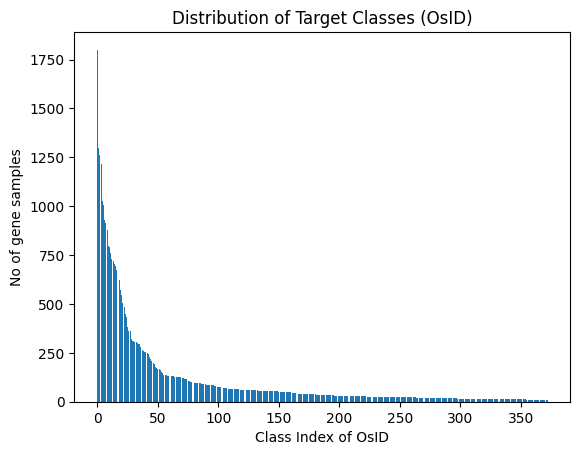

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=20, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Number of input features: 1
Fold: 1
Epoch 1/20
1846/1846 [==============================] - 7s 3ms/step - loss: 5.0095 - accuracy: 0.0384 - val_loss: 4.9188 - val_accuracy: 0.0750
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 4.5064 - accuracy: 0.0936 - val_loss: 4.2589 - val_accuracy: 0.1259
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.9801 - accuracy: 0.1319 - val_loss: 3.9394 - val_accuracy: 0.1538
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6590 - accuracy: 0.1709 - val_loss: 3.6618 - val_accuracy: 0.1916
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3850 - accuracy: 0.2296 - val_loss: 3.4353 - val_accuracy: 0.2345
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1642 - accuracy: 0.2543 - val_loss: 3.2860 - val_accuracy: 0.2284
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9970 - accuracy: 0.283

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 5.0156 - accuracy: 0.0414 - val_loss: 4.9387 - val_accuracy: 0.0768
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 4.5578 - accuracy: 0.0845 - val_loss: 4.3681 - val_accuracy: 0.1050
Epoch 3/20
1846/1846 [==============================] - 6s 4ms/step - loss: 4.0464 - accuracy: 0.1273 - val_loss: 4.0581 - val_accuracy: 0.1611
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7465 - accuracy: 0.1695 - val_loss: 3.8336 - val_accuracy: 0.1914
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4959 - accuracy: 0.2054 - val_loss: 3.6382 - val_accuracy: 0.2299
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.2885 - accuracy: 0.2519 - val_loss: 3.4925 - val_accuracy: 0.2768
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.1204 - accuracy: 0.2728 - val_loss: 3.3512 - val_accuracy: 0.2752
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.9557 - accuracy: 0.0477 - val_loss: 4.6096 - val_accuracy: 0.0708
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 4.2170 - accuracy: 0.1343 - val_loss: 4.0837 - val_accuracy: 0.1622
Epoch 3/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.7248 - accuracy: 0.1874 - val_loss: 3.6460 - val_accuracy: 0.2279
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3202 - accuracy: 0.2432 - val_loss: 3.3146 - val_accuracy: 0.2803
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0129 - accuracy: 0.2753 - val_loss: 3.0768 - val_accuracy: 0.3230
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7905 - accuracy: 0.3105 - val_loss: 2.9221 - val_accuracy: 0.2933
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.5906 - accuracy: 0.3473 - val_loss: 2.7007 - val_accuracy: 0.3595
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 5.0018 - accuracy: 0.0425 - val_loss: 4.7524 - val_accuracy: 0.0939
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 4.2904 - accuracy: 0.1092 - val_loss: 4.1489 - val_accuracy: 0.1828
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8274 - accuracy: 0.1833 - val_loss: 3.8366 - val_accuracy: 0.1978
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.4407 - accuracy: 0.2442 - val_loss: 3.5264 - val_accuracy: 0.2552
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0751 - accuracy: 0.3032 - val_loss: 3.1607 - val_accuracy: 0.3661
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.5972 - accuracy: 0.4019 - val_loss: 2.7016 - val_accuracy: 0.4471
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1271 - accuracy: 0.4903 - val_loss: 2.4032 - val_accuracy: 0.5485
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 5.0224 - accuracy: 0.0422 - val_loss: 4.8012 - val_accuracy: 0.0964
Epoch 2/20
1846/1846 [==============================] - 6s 4ms/step - loss: 4.3548 - accuracy: 0.1153 - val_loss: 4.1443 - val_accuracy: 0.2185
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5828 - accuracy: 0.2912 - val_loss: 3.4102 - val_accuracy: 0.3316
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.9582 - accuracy: 0.3869 - val_loss: 2.9190 - val_accuracy: 0.4022
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5269 - accuracy: 0.4429 - val_loss: 2.5967 - val_accuracy: 0.4521
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.2165 - accuracy: 0.4937 - val_loss: 2.3214 - val_accuracy: 0.4966
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9670 - accuracy: 0.5330 - val_loss: 2.1517 - val_accuracy: 0.5483
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.9821 - accuracy: 0.0451 - val_loss: 4.5929 - val_accuracy: 0.0768
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.9488 - accuracy: 0.2062 - val_loss: 3.6086 - val_accuracy: 0.3635
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0550 - accuracy: 0.3623 - val_loss: 3.0057 - val_accuracy: 0.4229
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.5026 - accuracy: 0.4511 - val_loss: 2.6168 - val_accuracy: 0.4988
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1178 - accuracy: 0.5248 - val_loss: 2.4201 - val_accuracy: 0.4893
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8418 - accuracy: 0.5730 - val_loss: 2.2956 - val_accuracy: 0.5710
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6479 - accuracy: 0.6067 - val_loss: 2.0576 - val_accuracy: 0.6317
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 5.0414 - accuracy: 0.0437 - val_loss: 4.8577 - val_accuracy: 0.0647
Epoch 2/20
1846/1846 [==============================] - 8s 4ms/step - loss: 4.3978 - accuracy: 0.1086 - val_loss: 4.1149 - val_accuracy: 0.2150
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4519 - accuracy: 0.3041 - val_loss: 3.1640 - val_accuracy: 0.3626
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6981 - accuracy: 0.4290 - val_loss: 2.6733 - val_accuracy: 0.4629
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2410 - accuracy: 0.5106 - val_loss: 2.3429 - val_accuracy: 0.5012
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.9275 - accuracy: 0.5688 - val_loss: 2.1351 - val_accuracy: 0.5619
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6885 - accuracy: 0.6199 - val_loss: 1.9655 - val_accuracy: 0.6499
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 3ms/step - loss: 4.5934 - accuracy: 0.0882 - val_loss: 4.0875 - val_accuracy: 0.1573
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4886 - accuracy: 0.2821 - val_loss: 3.2864 - val_accuracy: 0.3626
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6662 - accuracy: 0.4409 - val_loss: 2.6776 - val_accuracy: 0.5540
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0657 - accuracy: 0.5598 - val_loss: 2.3316 - val_accuracy: 0.5569
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6898 - accuracy: 0.6154 - val_loss: 2.0806 - val_accuracy: 0.6414
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4560 - accuracy: 0.6589 - val_loss: 2.0393 - val_accuracy: 0.5930
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3111 - accuracy: 0.6884 - val_loss: 1.8175 - val_accuracy: 0.7074
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.5714 - accuracy: 0.0913 - val_loss: 3.9889 - val_accuracy: 0.1622
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.3534 - accuracy: 0.3174 - val_loss: 3.0383 - val_accuracy: 0.4561
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4617 - accuracy: 0.4880 - val_loss: 2.3681 - val_accuracy: 0.5776
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.8451 - accuracy: 0.5897 - val_loss: 1.9523 - val_accuracy: 0.6284
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4806 - accuracy: 0.6530 - val_loss: 1.7377 - val_accuracy: 0.6561
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2702 - accuracy: 0.6866 - val_loss: 1.6153 - val_accuracy: 0.6763
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.1347 - accuracy: 0.7137 - val_loss: 1.4545 - val_accuracy: 0.7190
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.5792 - accuracy: 0.0831 - val_loss: 3.9963 - val_accuracy: 0.1265
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.3155 - accuracy: 0.3043 - val_loss: 3.0278 - val_accuracy: 0.4103
Epoch 3/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.4720 - accuracy: 0.4644 - val_loss: 2.5730 - val_accuracy: 0.5457
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9833 - accuracy: 0.5547 - val_loss: 2.2455 - val_accuracy: 0.5611
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6438 - accuracy: 0.6158 - val_loss: 2.0296 - val_accuracy: 0.6198
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4110 - accuracy: 0.6590 - val_loss: 1.8909 - val_accuracy: 0.6581
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.2567 - accuracy: 0.6927 - val_loss: 1.7362 - val_accuracy: 0.6825
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.7266 - accuracy: 0.0752 - val_loss: 4.1741 - val_accuracy: 0.1668
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6731 - accuracy: 0.2617 - val_loss: 3.4550 - val_accuracy: 0.3899
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9537 - accuracy: 0.4188 - val_loss: 2.8800 - val_accuracy: 0.4515
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.4437 - accuracy: 0.4649 - val_loss: 2.5234 - val_accuracy: 0.4849
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0696 - accuracy: 0.5305 - val_loss: 2.2192 - val_accuracy: 0.5327
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7777 - accuracy: 0.5922 - val_loss: 1.9916 - val_accuracy: 0.6275
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5406 - accuracy: 0.6447 - val_loss: 1.8437 - val_accuracy: 0.6640
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.8949 - accuracy: 0.0551 - val_loss: 4.3733 - val_accuracy: 0.0827
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7898 - accuracy: 0.2231 - val_loss: 3.6081 - val_accuracy: 0.3021
Epoch 3/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.0552 - accuracy: 0.3951 - val_loss: 3.1407 - val_accuracy: 0.4304
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4830 - accuracy: 0.4921 - val_loss: 2.7046 - val_accuracy: 0.5175
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0476 - accuracy: 0.5734 - val_loss: 2.4264 - val_accuracy: 0.5806
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7258 - accuracy: 0.6363 - val_loss: 2.1726 - val_accuracy: 0.6568
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4938 - accuracy: 0.6752 - val_loss: 2.1168 - val_accuracy: 0.6211
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.4404 - accuracy: 0.0943 - val_loss: 3.9178 - val_accuracy: 0.1798
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.3625 - accuracy: 0.2985 - val_loss: 3.1337 - val_accuracy: 0.3916
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5803 - accuracy: 0.4672 - val_loss: 2.5578 - val_accuracy: 0.5173
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0219 - accuracy: 0.5683 - val_loss: 2.0842 - val_accuracy: 0.5848
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6197 - accuracy: 0.6432 - val_loss: 1.7876 - val_accuracy: 0.6609
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3541 - accuracy: 0.6886 - val_loss: 1.6161 - val_accuracy: 0.6865
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.1862 - accuracy: 0.7181 - val_loss: 1.4977 - val_accuracy: 0.7184
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.7849 - accuracy: 0.0684 - val_loss: 4.1937 - val_accuracy: 0.1450
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7055 - accuracy: 0.2080 - val_loss: 3.5374 - val_accuracy: 0.2537
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9822 - accuracy: 0.3996 - val_loss: 2.9814 - val_accuracy: 0.4594
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3403 - accuracy: 0.5127 - val_loss: 2.5558 - val_accuracy: 0.5377
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8885 - accuracy: 0.5806 - val_loss: 2.2715 - val_accuracy: 0.6020
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5970 - accuracy: 0.6365 - val_loss: 2.1095 - val_accuracy: 0.6497
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3977 - accuracy: 0.6710 - val_loss: 1.9873 - val_accuracy: 0.6867
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 3ms/step - loss: 4.5591 - accuracy: 0.0791 - val_loss: 4.0902 - val_accuracy: 0.0911
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6090 - accuracy: 0.2084 - val_loss: 3.4065 - val_accuracy: 0.2821
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8526 - accuracy: 0.4295 - val_loss: 2.7620 - val_accuracy: 0.4717
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2406 - accuracy: 0.5499 - val_loss: 2.2903 - val_accuracy: 0.5721
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8055 - accuracy: 0.6191 - val_loss: 1.9752 - val_accuracy: 0.6400
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5241 - accuracy: 0.6624 - val_loss: 1.7738 - val_accuracy: 0.6499
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3389 - accuracy: 0.6878 - val_loss: 1.6041 - val_accuracy: 0.6807
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.5772 - accuracy: 0.0833 - val_loss: 4.0398 - val_accuracy: 0.1914
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.4515 - accuracy: 0.3149 - val_loss: 3.3168 - val_accuracy: 0.4024
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.7118 - accuracy: 0.4606 - val_loss: 2.8403 - val_accuracy: 0.5056
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1859 - accuracy: 0.5385 - val_loss: 2.4656 - val_accuracy: 0.5980
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.8178 - accuracy: 0.6161 - val_loss: 2.2405 - val_accuracy: 0.6326
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.5667 - accuracy: 0.6444 - val_loss: 2.1643 - val_accuracy: 0.6143
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3875 - accuracy: 0.6701 - val_loss: 1.9596 - val_accuracy: 0.6451
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.5340 - accuracy: 0.0823 - val_loss: 4.0374 - val_accuracy: 0.0961
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.4985 - accuracy: 0.2235 - val_loss: 3.2366 - val_accuracy: 0.3558
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6721 - accuracy: 0.4570 - val_loss: 2.5488 - val_accuracy: 0.5272
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0574 - accuracy: 0.5700 - val_loss: 2.1081 - val_accuracy: 0.5967
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6312 - accuracy: 0.6396 - val_loss: 1.7831 - val_accuracy: 0.6284
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3548 - accuracy: 0.6878 - val_loss: 1.5780 - val_accuracy: 0.6876
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.1670 - accuracy: 0.7181 - val_loss: 1.4440 - val_accuracy: 0.7298
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.5641 - accuracy: 0.0918 - val_loss: 3.9178 - val_accuracy: 0.2425
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3104 - accuracy: 0.3076 - val_loss: 3.2116 - val_accuracy: 0.3989
Epoch 3/20
1846/1846 [==============================] - 8s 4ms/step - loss: 2.5869 - accuracy: 0.4720 - val_loss: 2.7457 - val_accuracy: 0.4891
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1063 - accuracy: 0.5406 - val_loss: 2.4532 - val_accuracy: 0.5646
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7852 - accuracy: 0.6025 - val_loss: 2.2315 - val_accuracy: 0.5791
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5678 - accuracy: 0.6415 - val_loss: 2.0467 - val_accuracy: 0.6570
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3983 - accuracy: 0.6728 - val_loss: 1.9062 - val_accuracy: 0.6990
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.4996 - accuracy: 0.0901 - val_loss: 4.0119 - val_accuracy: 0.1666
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5000 - accuracy: 0.2313 - val_loss: 3.1777 - val_accuracy: 0.3410
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.5476 - accuracy: 0.4661 - val_loss: 2.4100 - val_accuracy: 0.5470
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.9491 - accuracy: 0.5761 - val_loss: 1.9603 - val_accuracy: 0.6284
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5604 - accuracy: 0.6440 - val_loss: 1.7157 - val_accuracy: 0.6651
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3124 - accuracy: 0.6890 - val_loss: 1.5056 - val_accuracy: 0.6911
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.1378 - accuracy: 0.7241 - val_loss: 1.4391 - val_accuracy: 0.7056
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.5100 - accuracy: 0.0890 - val_loss: 4.0978 - val_accuracy: 0.2216
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6418 - accuracy: 0.1913 - val_loss: 3.5278 - val_accuracy: 0.2464
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8986 - accuracy: 0.3762 - val_loss: 2.8036 - val_accuracy: 0.4724
Epoch 4/20
1846/1846 [==============================] - 6s 4ms/step - loss: 2.2103 - accuracy: 0.5034 - val_loss: 2.4042 - val_accuracy: 0.5404
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7564 - accuracy: 0.5990 - val_loss: 2.0779 - val_accuracy: 0.5837
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4618 - accuracy: 0.6588 - val_loss: 1.8862 - val_accuracy: 0.6473
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2625 - accuracy: 0.6931 - val_loss: 1.7000 - val_accuracy: 0.6966
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/20
1846/1846 [==============================] - 7s 3ms/step - loss: 4.5513 - accuracy: 0.0736 - val_loss: 4.1303 - val_accuracy: 0.1118
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.5771 - accuracy: 0.2240 - val_loss: 3.2999 - val_accuracy: 0.3322
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7007 - accuracy: 0.4265 - val_loss: 2.5251 - val_accuracy: 0.4827
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9814 - accuracy: 0.5534 - val_loss: 1.9930 - val_accuracy: 0.6024
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5255 - accuracy: 0.6423 - val_loss: 1.6759 - val_accuracy: 0.6684
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2338 - accuracy: 0.7016 - val_loss: 1.5216 - val_accuracy: 0.6845
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.0536 - accuracy: 0.7348 - val_loss: 1.3495 - val_accuracy:

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 3ms/step - loss: 4.5304 - accuracy: 0.0818 - val_loss: 4.1060 - val_accuracy: 0.1452
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6384 - accuracy: 0.1893 - val_loss: 3.5044 - val_accuracy: 0.2759
Epoch 3/20
1846/1846 [==============================] - 6s 4ms/step - loss: 2.9635 - accuracy: 0.3477 - val_loss: 2.8353 - val_accuracy: 0.4475
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3276 - accuracy: 0.4808 - val_loss: 2.3843 - val_accuracy: 0.5109
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.8404 - accuracy: 0.5771 - val_loss: 1.9935 - val_accuracy: 0.5980
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4546 - accuracy: 0.6610 - val_loss: 1.7152 - val_accuracy: 0.6961
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.2013 - accuracy: 0.7082 - val_loss: 1.5770 - val_accuracy: 0.7184
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.5405 - accuracy: 0.0768 - val_loss: 4.0733 - val_accuracy: 0.1111
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5051 - accuracy: 0.2498 - val_loss: 3.1901 - val_accuracy: 0.4134
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5954 - accuracy: 0.4588 - val_loss: 2.5038 - val_accuracy: 0.5107
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.9687 - accuracy: 0.5751 - val_loss: 2.0782 - val_accuracy: 0.6304
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5792 - accuracy: 0.6497 - val_loss: 1.7415 - val_accuracy: 0.6585
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3337 - accuracy: 0.6904 - val_loss: 1.5871 - val_accuracy: 0.6937
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.1645 - accuracy: 0.7273 - val_loss: 1.4401 - val_accuracy: 0.7305
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.6484 - accuracy: 0.0652 - val_loss: 4.2650 - val_accuracy: 0.1124
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.7228 - accuracy: 0.1828 - val_loss: 3.3661 - val_accuracy: 0.3083
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6894 - accuracy: 0.4127 - val_loss: 2.6617 - val_accuracy: 0.4774
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0452 - accuracy: 0.5525 - val_loss: 2.2484 - val_accuracy: 0.6057
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6326 - accuracy: 0.6280 - val_loss: 2.0008 - val_accuracy: 0.6499
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4063 - accuracy: 0.6692 - val_loss: 1.7996 - val_accuracy: 0.6744
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2551 - accuracy: 0.6965 - val_loss: 1.7061 - val_accuracy: 0.6986
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/20
1846/1846 [==============================] - 7s 3ms/step - loss: 4.5328 - accuracy: 0.0931 - val_loss: 3.9977 - val_accuracy: 0.1503
Epoch 2/20
1846/1846 [==============================] - 8s 4ms/step - loss: 3.5802 - accuracy: 0.2039 - val_loss: 3.3972 - val_accuracy: 0.2473
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0044 - accuracy: 0.3071 - val_loss: 2.9172 - val_accuracy: 0.3633
Epoch 4/20
1846/1846 [==============================] - 6s 4ms/step - loss: 2.4229 - accuracy: 0.4483 - val_loss: 2.3124 - val_accuracy: 0.5377
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.8316 - accuracy: 0.5836 - val_loss: 1.8767 - val_accuracy: 0.6251
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4420 - accuracy: 0.6691 - val_loss: 1.5795 - val_accuracy: 0.6860
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2025 - accuracy: 0.7132 - val_loss: 1.4049 - val_accuracy:

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.5293 - accuracy: 0.0819 - val_loss: 4.0478 - val_accuracy: 0.1281
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5936 - accuracy: 0.1809 - val_loss: 3.4954 - val_accuracy: 0.2873
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9746 - accuracy: 0.3349 - val_loss: 2.9006 - val_accuracy: 0.3718
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3111 - accuracy: 0.4770 - val_loss: 2.3958 - val_accuracy: 0.5564
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7988 - accuracy: 0.5979 - val_loss: 2.0548 - val_accuracy: 0.6304
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4518 - accuracy: 0.6717 - val_loss: 1.8409 - val_accuracy: 0.6788
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2339 - accuracy: 0.7076 - val_loss: 1.6752 - val_accuracy: 0.7206
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/20
1846/1846 [==============================] - 7s 3ms/step - loss: 4.7218 - accuracy: 0.0749 - val_loss: 4.1881 - val_accuracy: 0.1204
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.7511 - accuracy: 0.1710 - val_loss: 3.6288 - val_accuracy: 0.2634
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0428 - accuracy: 0.3645 - val_loss: 2.9311 - val_accuracy: 0.4471
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4251 - accuracy: 0.4949 - val_loss: 2.5111 - val_accuracy: 0.5265
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0019 - accuracy: 0.5538 - val_loss: 2.1940 - val_accuracy: 0.5877
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6746 - accuracy: 0.6214 - val_loss: 1.9878 - val_accuracy: 0.6539
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4258 - accuracy: 0.6711 - val_loss: 1.8288 - val_accuracy:

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.6276 - accuracy: 0.0733 - val_loss: 4.1142 - val_accuracy: 0.0961
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6658 - accuracy: 0.1804 - val_loss: 3.5169 - val_accuracy: 0.2772
Epoch 3/20
1846/1846 [==============================] - 6s 4ms/step - loss: 2.9369 - accuracy: 0.3621 - val_loss: 2.8822 - val_accuracy: 0.4152
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2751 - accuracy: 0.5098 - val_loss: 2.4493 - val_accuracy: 0.5274
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8121 - accuracy: 0.6069 - val_loss: 2.2259 - val_accuracy: 0.6141
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.5068 - accuracy: 0.6616 - val_loss: 2.0263 - val_accuracy: 0.6849
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2986 - accuracy: 0.7078 - val_loss: 1.9223 - val_accuracy: 0.6909
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.7983 - accuracy: 0.0598 - val_loss: 4.2999 - val_accuracy: 0.1025
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8116 - accuracy: 0.1533 - val_loss: 3.6368 - val_accuracy: 0.1503
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1732 - accuracy: 0.2944 - val_loss: 3.1043 - val_accuracy: 0.3228
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6215 - accuracy: 0.4530 - val_loss: 2.6520 - val_accuracy: 0.4948
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1803 - accuracy: 0.5427 - val_loss: 2.2986 - val_accuracy: 0.5721
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8297 - accuracy: 0.6095 - val_loss: 2.0629 - val_accuracy: 0.6108
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5710 - accuracy: 0.6503 - val_loss: 1.8713 - val_accuracy: 0.6425
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.5873 - accuracy: 0.0781 - val_loss: 4.1238 - val_accuracy: 0.1395
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6500 - accuracy: 0.1821 - val_loss: 3.4721 - val_accuracy: 0.2233
Epoch 3/20
1846/1846 [==============================] - 6s 4ms/step - loss: 2.9194 - accuracy: 0.3605 - val_loss: 2.9429 - val_accuracy: 0.4539
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2830 - accuracy: 0.5241 - val_loss: 2.4156 - val_accuracy: 0.5439
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8232 - accuracy: 0.5928 - val_loss: 2.1444 - val_accuracy: 0.6057
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5316 - accuracy: 0.6431 - val_loss: 1.9878 - val_accuracy: 0.6418
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3361 - accuracy: 0.6874 - val_loss: 1.8216 - val_accuracy: 0.7089
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.6965 - accuracy: 0.0764 - val_loss: 4.1954 - val_accuracy: 0.0994
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7570 - accuracy: 0.1599 - val_loss: 3.5646 - val_accuracy: 0.2092
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0975 - accuracy: 0.3070 - val_loss: 2.8659 - val_accuracy: 0.4616
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4014 - accuracy: 0.4928 - val_loss: 2.3428 - val_accuracy: 0.5221
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.9400 - accuracy: 0.5770 - val_loss: 1.9576 - val_accuracy: 0.6092
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6137 - accuracy: 0.6411 - val_loss: 1.7331 - val_accuracy: 0.6568
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3940 - accuracy: 0.6830 - val_loss: 1.5889 - val_accuracy: 0.6862
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.5960 - accuracy: 0.0884 - val_loss: 4.0951 - val_accuracy: 0.1358
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6764 - accuracy: 0.1743 - val_loss: 3.4951 - val_accuracy: 0.2183
Epoch 3/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.9753 - accuracy: 0.3312 - val_loss: 2.7714 - val_accuracy: 0.4616
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2728 - accuracy: 0.5111 - val_loss: 2.3478 - val_accuracy: 0.5597
Epoch 5/20
1846/1846 [==============================] - 8s 4ms/step - loss: 1.8378 - accuracy: 0.6047 - val_loss: 2.0475 - val_accuracy: 0.5952
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.5547 - accuracy: 0.6529 - val_loss: 1.8701 - val_accuracy: 0.6748
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3669 - accuracy: 0.6877 - val_loss: 1.7016 - val_accuracy: 0.6942
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.7570 - accuracy: 0.0677 - val_loss: 4.2805 - val_accuracy: 0.1177
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.9355 - accuracy: 0.1523 - val_loss: 3.8317 - val_accuracy: 0.1740
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5163 - accuracy: 0.1989 - val_loss: 3.4538 - val_accuracy: 0.2216
Epoch 4/20
1846/1846 [==============================] - 8s 4ms/step - loss: 3.0420 - accuracy: 0.2907 - val_loss: 2.9085 - val_accuracy: 0.3556
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5059 - accuracy: 0.4137 - val_loss: 2.4874 - val_accuracy: 0.4667
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.1500 - accuracy: 0.4937 - val_loss: 2.2469 - val_accuracy: 0.5052
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.9259 - accuracy: 0.5375 - val_loss: 2.0904 - val_accuracy: 0.5463
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 3ms/step - loss: 4.7998 - accuracy: 0.0593 - val_loss: 4.3562 - val_accuracy: 0.0645
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.9343 - accuracy: 0.1414 - val_loss: 3.8117 - val_accuracy: 0.1760
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4469 - accuracy: 0.1990 - val_loss: 3.4209 - val_accuracy: 0.2220
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9792 - accuracy: 0.3004 - val_loss: 2.9633 - val_accuracy: 0.3292
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.5171 - accuracy: 0.4100 - val_loss: 2.5646 - val_accuracy: 0.4823
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1551 - accuracy: 0.4930 - val_loss: 2.3000 - val_accuracy: 0.4946
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8859 - accuracy: 0.5469 - val_loss: 2.0911 - val_accuracy: 0.5230
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 10s 4ms/step - loss: 4.8260 - accuracy: 0.0632 - val_loss: 4.4654 - val_accuracy: 0.1054
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.0475 - accuracy: 0.1379 - val_loss: 3.8865 - val_accuracy: 0.1573
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6338 - accuracy: 0.1849 - val_loss: 3.6310 - val_accuracy: 0.1914
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.4026 - accuracy: 0.2110 - val_loss: 3.4443 - val_accuracy: 0.2075
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.2090 - accuracy: 0.2406 - val_loss: 3.2841 - val_accuracy: 0.2477
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.0064 - accuracy: 0.2816 - val_loss: 3.1072 - val_accuracy: 0.2781
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.7933 - accuracy: 0.3380 - val_loss: 2.8989 - val_accuracy: 0.3476
Ep

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.8163 - accuracy: 0.0619 - val_loss: 4.3928 - val_accuracy: 0.0895
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.9913 - accuracy: 0.1350 - val_loss: 3.8440 - val_accuracy: 0.1740
Epoch 3/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5517 - accuracy: 0.1848 - val_loss: 3.5252 - val_accuracy: 0.2062
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.2165 - accuracy: 0.2268 - val_loss: 3.2498 - val_accuracy: 0.2570
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.8220 - accuracy: 0.3302 - val_loss: 2.8700 - val_accuracy: 0.3738
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4430 - accuracy: 0.4209 - val_loss: 2.5918 - val_accuracy: 0.4403
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.1649 - accuracy: 0.4737 - val_loss: 2.3572 - val_accuracy: 0.4719
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.8179 - accuracy: 0.0611 - val_loss: 4.3969 - val_accuracy: 0.1010
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.0097 - accuracy: 0.1507 - val_loss: 3.8537 - val_accuracy: 0.1531
Epoch 3/20
1846/1846 [==============================] - 8s 4ms/step - loss: 3.5157 - accuracy: 0.2014 - val_loss: 3.4336 - val_accuracy: 0.2075
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.0140 - accuracy: 0.3034 - val_loss: 2.9344 - val_accuracy: 0.3388
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.5359 - accuracy: 0.4111 - val_loss: 2.5583 - val_accuracy: 0.4277
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2051 - accuracy: 0.4736 - val_loss: 2.2927 - val_accuracy: 0.4898
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9710 - accuracy: 0.5132 - val_loss: 2.1365 - val_accuracy: 0.5298
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.8719 - accuracy: 0.0561 - val_loss: 4.5377 - val_accuracy: 0.0700
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 4.0724 - accuracy: 0.1286 - val_loss: 3.9255 - val_accuracy: 0.1723
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6396 - accuracy: 0.1845 - val_loss: 3.6502 - val_accuracy: 0.1877
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.3797 - accuracy: 0.2098 - val_loss: 3.4678 - val_accuracy: 0.2066
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1737 - accuracy: 0.2376 - val_loss: 3.3221 - val_accuracy: 0.2339
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9550 - accuracy: 0.2803 - val_loss: 3.0569 - val_accuracy: 0.3019
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7130 - accuracy: 0.3307 - val_loss: 2.8450 - val_accuracy: 0.3732
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 3ms/step - loss: 4.8674 - accuracy: 0.0590 - val_loss: 4.5183 - val_accuracy: 0.0691
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1304 - accuracy: 0.1277 - val_loss: 3.9994 - val_accuracy: 0.1512
Epoch 3/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.7270 - accuracy: 0.1743 - val_loss: 3.7018 - val_accuracy: 0.2022
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4200 - accuracy: 0.2104 - val_loss: 3.4079 - val_accuracy: 0.2172
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0944 - accuracy: 0.2677 - val_loss: 3.1081 - val_accuracy: 0.2906
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.7434 - accuracy: 0.3446 - val_loss: 2.7561 - val_accuracy: 0.3751
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4476 - accuracy: 0.4070 - val_loss: 2.5586 - val_accuracy: 0.4178
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.8654 - accuracy: 0.0544 - val_loss: 4.5617 - val_accuracy: 0.0834
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.0876 - accuracy: 0.1288 - val_loss: 3.9607 - val_accuracy: 0.1481
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6331 - accuracy: 0.1836 - val_loss: 3.6660 - val_accuracy: 0.1901
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3167 - accuracy: 0.2290 - val_loss: 3.3643 - val_accuracy: 0.2642
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.9906 - accuracy: 0.2941 - val_loss: 3.0811 - val_accuracy: 0.3384
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.6532 - accuracy: 0.3672 - val_loss: 2.7762 - val_accuracy: 0.4145
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3523 - accuracy: 0.4328 - val_loss: 2.5143 - val_accuracy: 0.4847
Epo

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

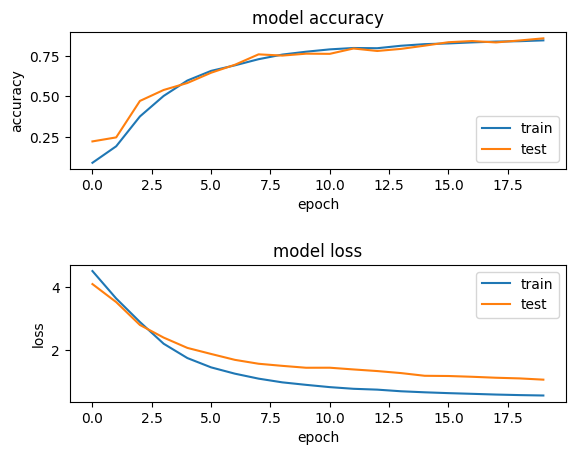

Final Test Accuracy: 0.861797034740448


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       0.91      1.00      0.95       294
           9       0.97      1.00      0.99       269
          10       0.97      1.00      0.99       296
          11       0.96      1.00      0.98       258
          12       1.00      1.00      1.00       247
          13       0.96      1.00      0.98       237
          14       0.84      1.00      0.91       239
          15       1.00      1.00      1.00       235
  

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os04g0475500         328              239       False
1  Os04g0659100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.423
1,2,0.709
2,3,0.750
3,4,0.796
4,5,0.814
5,6,0.825
6,7,0.817
7,8,0.827
8,9,0.835
9,10,0.862
